# Neural Network training using Levenberg-Marquardt Algorithm

In [3]:
import numpy as np

In [4]:
"""
Gradient of f_w(x) with respect to w
    :param w: np.ndarray of size p, the weights of the neural network
    :param tanh: the function tanh
    :param d_tanh: the derivative of the function tanh
    :param x: np.ndarray of size n, the input to evaluate the gradient on
    :returns grad: np.ndarray of size 16, the  
"""
def grad_f(w, tanh, d_tanh, x):
    grad = np.zeros(16)
    
    args = [0.0] * 3
    
    for i in range(0, 11, 5):
        args[i // 5] = w[i+1]*x[0] + w[i+2]*x[1] + w[i+3]*x[2] + w[i+4]
    
    for i in range(0, 11, 5):
        grad[i] = tanh(args[i // 5])
        
    for i in range(1, 12, 5):
        for j in range(4):
            grad[i+j] = w[i-1] * d_tanh(args[(i-1) // 5]) * (x[j] if j < 3 else 1.0)
            
    grad[15] = 1.0

    return grad

#### Let's call the output of the neural network, given its weights $w$, $f_w$
#### Considering the NN architecture we get that
$$f_w(x) = w_1\phi(w_2x_1 + w_3x_2 + w_4x_3 + w_5) + w_6\phi(w_7x_1 + w_8x_2 + w_9x_3 + w_{10}) + w_{11}\phi(w_{12}x_1 + w_{13}x_2 + w_{14}x_3 + w_{15}) + w_{16}$$
#### and by differentiating
$$\nabla_wf_w(x)_i =
\begin{cases}
    \phi(w_{i+1}x_1 + w_{i+2}x_2 + w_{i+3}x_3 + w_{i+4}) & \text{if } i \in \{1, 6, 11\}\\
    1 & \text{if } i = 16 \\
    w_j \phi'(w_{j+1}x_1 + w_{j+2}x_2 + w_{j+3}x_3 + w_{j+4}) \text{ with } j=5\lfloor{\frac{i-1}{5}}\rfloor+1 & \text{if } i \in \{5, 10, 15\}\\
    w_j \phi'(w_{j+1}x_1 + w_{j+2}x_2 + w_{j+3}x_3 + w_{j+4}) x_{i-j} \text{ with } j=5\lfloor{\frac{i-1}{5}}\rfloor+1 & \text{otherwise }
\end{cases}
$$


***

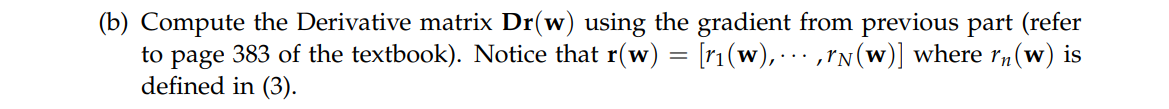

#### Let's call $r(w)$ the residual:
$$r(w) = 
\begin{pmatrix} 
r_1(w) \\
\vdots \\
r_N(w)
\end{pmatrix} = 
\begin{pmatrix} 
f_w(x^{(1)}) - y^{(1)} \\
\vdots \\
f_w(x^{(N)}) - y^{(N)} \\
\end{pmatrix}
$$

In [1]:
"""
Class to generate Jacobian of residual:
"""
class Dr:
    """
    Initialize Jacobian shape (Nx16) and store data points x
    since they don't vary across Jacobian evaluations
    """
    def __init__(self, tanh, dtanh, x):
        self.__N = x.shape[0]
        self.__tanh = tanh
        self.__dtanh = dtanh
        self.__x = np.copy(x)
        self.__Dr = np.zeros((self.__N, 16))
    
    """
    Returns the Jacobian evaluated on
    the input weights w
    """
    def __call__(self, w):
        for i in range(self.__N):
            self.__Dr[i] = grad_f(w, self.__tanh, self.__dtanh, self.__x[i])
        return self.__Dr
    

#### The Derivative matrix $Dr(w)$ is defined as:
$$Dr(w) = 
\begin{pmatrix} 
\nabla_wr_1(w) \\
\vdots \\
\nabla_wr_N(w)
\end{pmatrix}$$

#### Since 
$$\nabla_wr_i(w) = \nabla_w[f_w(x^{(i)}) - y^{(i)}] = \nabla_wf_w(x^{(i)}) - \nabla_wy^{(i)} = \nabla_wf_w(x^{(i)})$$

#### we get
$$Dr(w) = 
\begin{pmatrix} 
\nabla_wf_w(x^{(1)}) \\
\vdots \\
\nabla_wf_w(x^{(N)})
\end{pmatrix}$$

***

#### We will train the Neural Network to approximate the non-linear function $g(x) = x_1 x_2 + x_3$.
#### The data will be generated on $N = 500$ random points $x^{(n)} \in \mathbb{R}^3$

#### The function to be minimized will be 
$$
l(w) = \|r(w)\|_2^2 + \lambda\|w\|_2^2 = 
    \begin{Vmatrix}
    \begin{bmatrix}
        r_1(w) \\
        \vdots \\
        r_N(w) \\
        \\
        \sqrt{\lambda}w
        \\
        \\
    \end{bmatrix}
    \end{Vmatrix}_2^2
$$

In [6]:
"""
Generate datapoints
    :param g: the function to approximate
    :param N: the number of datapoints to generate
    :param min_bound: the minimum value that x_i can have
    :param max_bound: the maximum value that x_i can have
    :returns (X, y): randomly generated datapoints and respective evaluation of g
"""
def generate_datapoints(g, N, min_bound, max_bound):
    X = np.random.uniform(min_bound, max_bound, (N, 3))
    y = np.array([g(X[i]) for i in range(N)])
    return (X, y)

In [7]:
def tanh(x):
    e_x = np.exp(x)
    return (e_x - 1.0/e_x) / (e_x + 1.0/e_x)

def dtanh(x):
    t = tanh(x)
    return 1 - t * t

In [8]:
"""
The function representing the output of the neural network, called f_w in the notes/report
"""
def NN(w, x):
    output = 0.0
    
    for i in range(0, 11, 5):
        output += w[i] * tanh(w[i+1]*x[0] + w[i+2]*x[1] + w[i+3]*x[2] + w[i+4])
    
    output += w[15]
    
    return output

"""
The function whose norm we are trying to minimize
"""
def f(w, X, y, lmb):
    N = X.shape[0]
    r = np.array([NN(w, X[i]) - y[i] for i in range(N)])
    lmb_w = np.sqrt(lmb) * w
    return np.concatenate((r, lmb_w), axis=None)

***

In [9]:
"""
Implementation of the Levenberg-Marquardt algorithm/heuristic
    :param X: np.array of shape Nx3, training data
    :param y: np.array of shape N, training labels
    :param lmb: parameter lambda that multiplies the norm squares of w
    :param w0: the starting point for the weights
    :returns 
        l -> values of the function we want to minimize, at each iteration
        gamma -> values taken by the parameter gamma during training, initial gamma = 1.0
        w -> final value of the weights after training
        optimality_condition -> final value of 2 * Df_w.T @ f_w, necessary condition for w to be an optimal solution
"""
def Levenberg_Marquardt(X, y, lmb, w0):
    # Stopping parameters
    kmax = 500
    tol1 = 1e-4
    tol2 = 1e-2
    
    # Initialize class instances and arrays
    J = Dr(tanh, dtanh, X)
    w_prev = np.full(16, np.inf)
    w = np.copy(w0)
    l = np.zeros(kmax)
    gamma = np.zeros(kmax)
    
    # Set starting values
    gamma[0] = 1.0
    optimality_condition = np.inf
    k = 0
    
    while k+1 < kmax:
        # only calculate vectors and matrices if the weights have changed
        if not np.array_equal(w_prev, w):
            f_wk = f(w, X, y, lmb)
        
            J_wk = J(w)
            Df_wk = np.vstack((J_wk, np.sqrt(lmb) * np.identity(16)))
        
        # calulate values for stopping conditions and check them
        l[k] = np.linalg.norm(f_wk) ** 2
        optimality_condition = np.linalg.norm(2 * Df_wk.T @ f_wk)
        if l[k] <= tol1 or optimality_condition <= tol2:
            k += 1
            break  
        
        # learning step
        w_prev = np.copy(w)
        w = w_prev - np.linalg.inv(Df_wk.T @ Df_wk + gamma[k] * np.identity(16)) @ Df_wk.T @ f_wk
             
        # check that we actually descented in the former non-linear function by descending in the Taylor approximation
        # update gamma (and next weights) accordingly
        if np.linalg.norm(f(w, X, y, lmb)) ** 2 < l[k]:
            gamma[k+1] = 0.8 * gamma[k]
        else:
            gamma[k+1] = 2 * gamma[k]
            w = np.copy(w_prev)
                
        k += 1  
    
    return (l[:k], gamma[:k], w, optimality_condition)

#### I have arbitrarily defined the following variables:
$$
k_{max} = 500 \\
tol_1 = 10^{-4} \\
tol_2 = 10^{-2} \\
\gamma_0 = 1
$$

#### Respectively: the maximum number of iterations, tolerance to consider $l(w) = 0$, tolerance to consider $\|2Df(w)^Tf(w)\|_2 = 0$,  the initial regularization parameter

#### The specified stopping criterion is the following: the algorithm runs for at most $k_{max}$ iterations, and stops early if either
$$ 
\; l(w) \le tol_1 \\
\text{or} \\
\; \|2Df(w)^Tf(w)\|_2 \le tol_2
$$

#### Respectively: the value of the function we want to minimize is almost zero or the optimality condition has almost been reached

In [10]:
import matplotlib.pyplot as plt

In [139]:
"""
Approximates matematical function using the defined Neural Network
    :param wi_bounds: np.array, every entry contains 2 values: the lower and upper bounds for the initial weights
"""
def approximate_function(wi_bounds, lambdas, g, N, N_Ts, x_bounds):
    
    # Generate training data
    (train_X, train_y) = generate_datapoints(g, N, x_bounds[0], x_bounds[1])
    
    # Generate testing data of different sizes
    test_Xs = []
    test_ys = []
    for i in range(len(N_Ts)):
        (tempX, tempy) = generate_datapoints(g, N_Ts[i], x_bounds[0], x_bounds[1])
        test_Xs.append(tempX)
        test_ys.append(tempy)

    # On every possible combination of weights initialization ...
    for i in range(wi_bounds.shape[0]):
        fig = plt.figure(figsize=(16, 5))
        fig.suptitle(f"Starting weights values in range {wi_bounds[i]}")
        w0 = np.random.uniform(wi_bounds[i][0], wi_bounds[i][1], 16)
        
        # ... and regularization parameter lambda
        for j in range(len(lambdas)):
            # Train the model
            l, gamma, w, opt = Levenberg_Marquardt(train_X, train_y, lambdas[j], w0)
            
            # Plot training error
            ax = fig.add_subplot(1 , len(lambdas) , j+1)
            ax.plot(l)
            ax.set_ylim(ymin=0)
            ax.set_title(f"Lambda = {lambdas[j]}")
            ax.set(xlabel='iteration k', ylabel='l(w_k)')
            ax.axhline(y=l[-1], c='red', ls='--')
            ax.text(-11, l[-1], round(l[-1],2), c='red')
            ax.text(0.5, -0.2, f"2 * Df_w.T @ f_w = {opt}", size=12, ha="center", transform=ax.transAxes)
            ax.text(0.5, -0.25, f"Training error: {l[-1]}", size=12, ha="center", transform=ax.transAxes)
            
            # Include testing error
            for k in range(len(N_Ts)):
                ax.text(0.5, -0.3 - 0.1 * k, f"Testing error (N_T = {N_Ts[k]}):  {round(np.linalg.norm(f(w, test_Xs[k], test_ys[k], lambdas[j])) ** 2, 4)}", size=12, ha="center", transform=ax.transAxes)
                ax.text(0.5, -0.35 - 0.1 * k, f"Normalized (MSE):  {round(np.linalg.norm(f(w, test_Xs[k], test_ys[k], lambdas[j])) ** 2 / N_Ts[k], 4)}", size=12, ha="center", transform=ax.transAxes)
        plt.show()
            
    return l, gamma, w

In [140]:
def g(x):
    return x[0] * x[1] + x[2]

In [141]:
lmbs = np.array([1e-3, 1e-5, 1e-7])
wi_bounds = np.array([[-1.0, 1.0], [-3.0, 3.0], [-5.0, 5.0]])

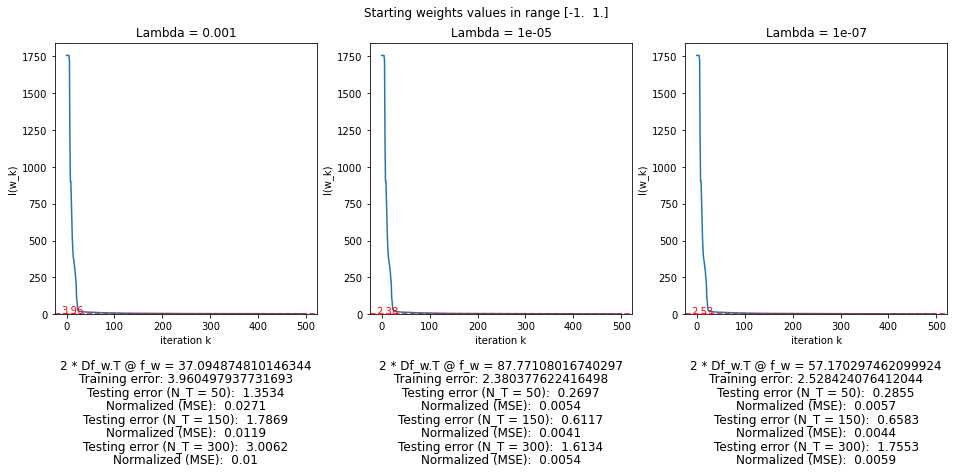

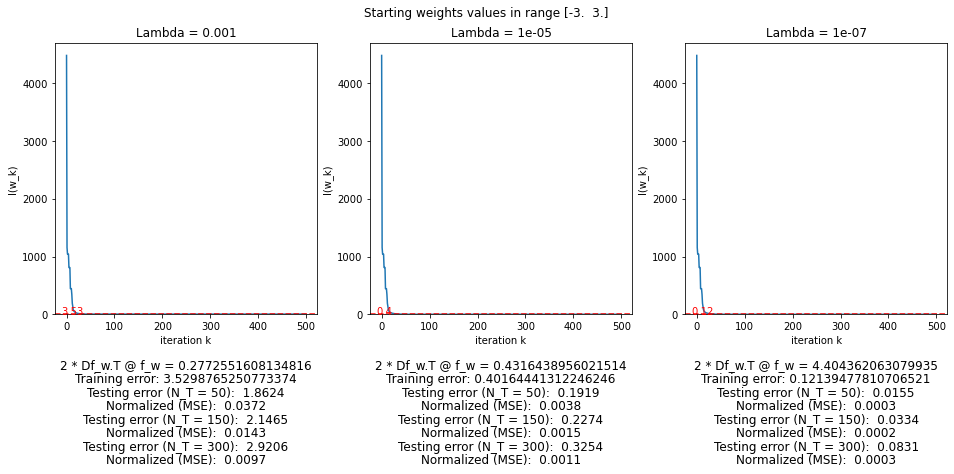

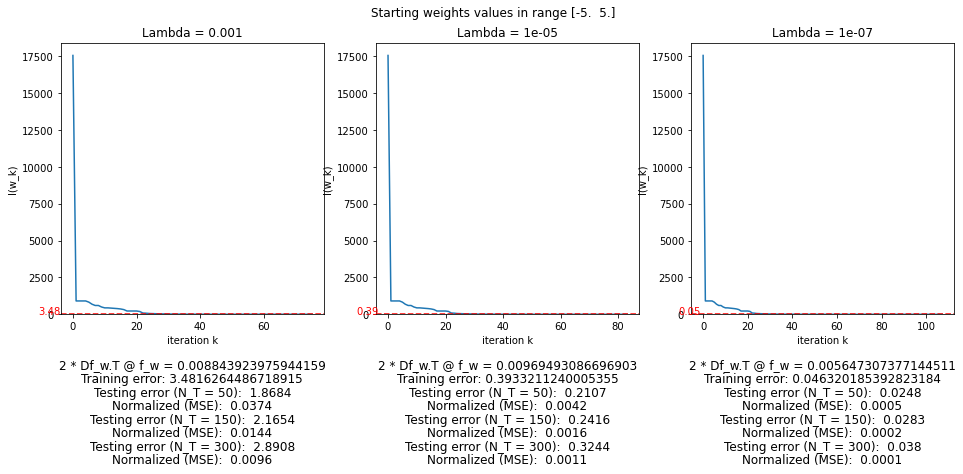

In [142]:
(l, gamma, w) = approximate_function(wi_bounds, lmbs, g, 500, [50, 150, 300], [-2.0, 2.0])

## Comments

#### The results indicate that the optimality condition is almost always reached in the cases with the 2nd and 3rd initialization values, while it is not in the 1st case. The testing error remains as low as the training error, which means that the model is not overfitting.

#### Higher values of the parameter $\lambda$ yield worst results consistently

### Note: input space for the generation phase
#### Let's see the different training error we obtain by changing the range of inputs to g and the number of training points accordingly

#### 500 data points with $x_i \in [-2, 2]$

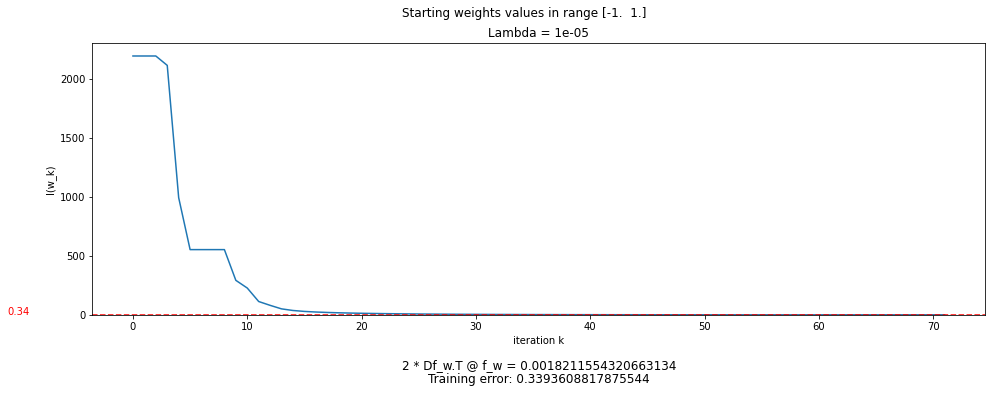

In [144]:
(_, _, _) = approximate_function(np.array([[-1.0, 1.0]]), np.array([1e-5]), g, 500, [], [-2.0, 2.0])

#### 500 data points with $x_i \in [-8, 8]$

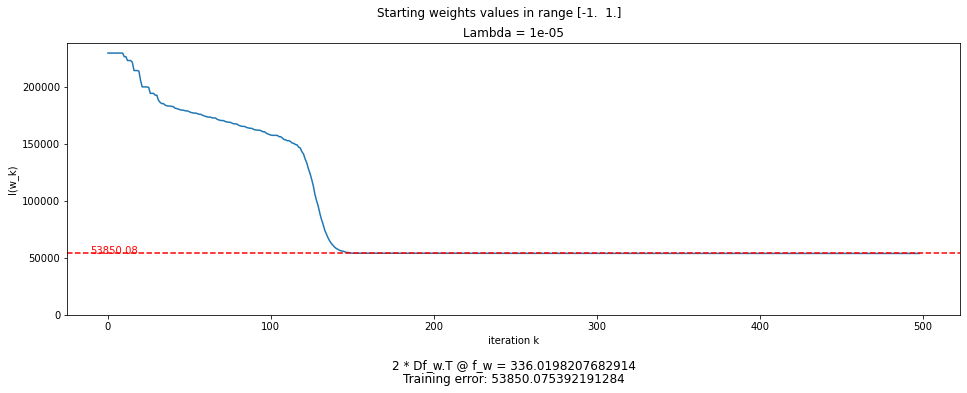

In [154]:
(_, _, _) = approximate_function(np.array([[-1.0, 1.0]]), np.array([1e-5]), g, 500, [], [-8.0, 8.0])

#### 800 data points with $x_i \in [-8, 8]$

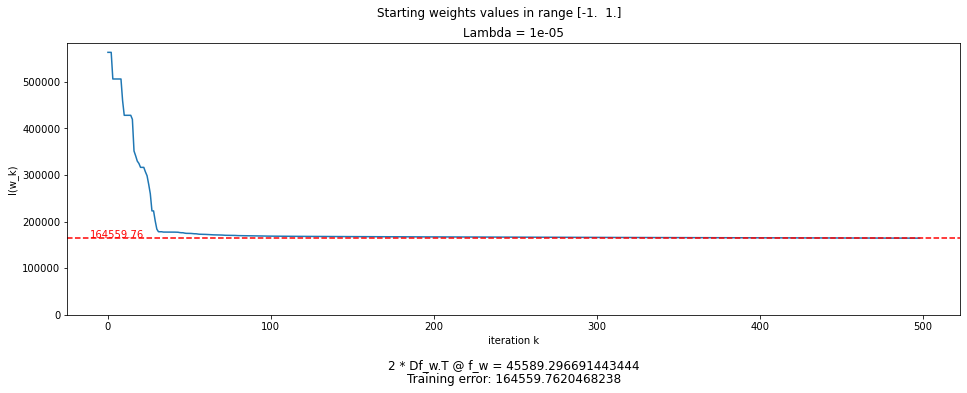

In [155]:
(_, _, _) = approximate_function(np.array([[-1.0, 1.0]]), np.array([1e-5]), g, 1200, [], [-8.0, 8.0])

#### Increasing the number of datapoints didn't imply a dicrease in the training error, instead it caused an increase

***

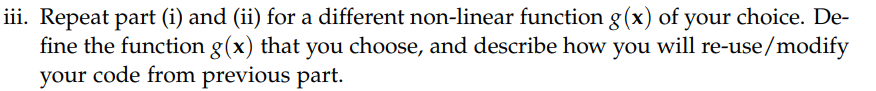

#### The code has been modularized in a way to be re-use by just giving a different function $g$ as input

In [156]:
def g_new(x):
    return x[0] * (x[1] + x[2])

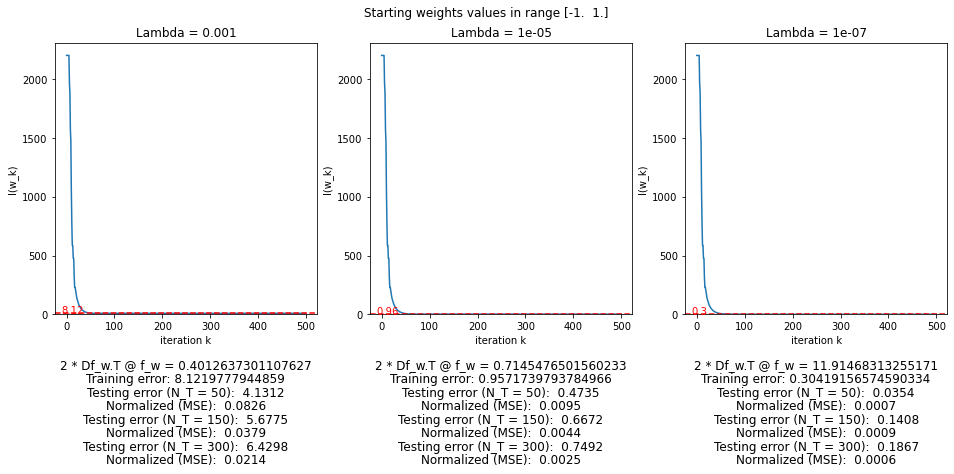

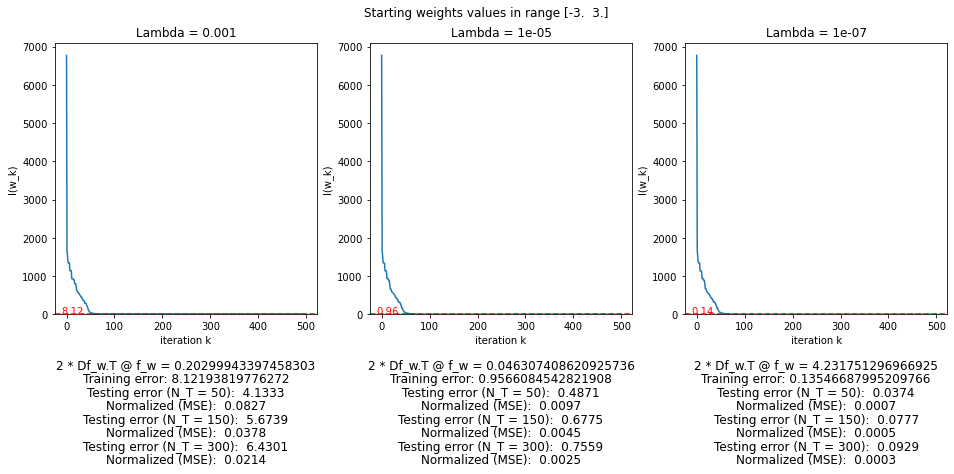

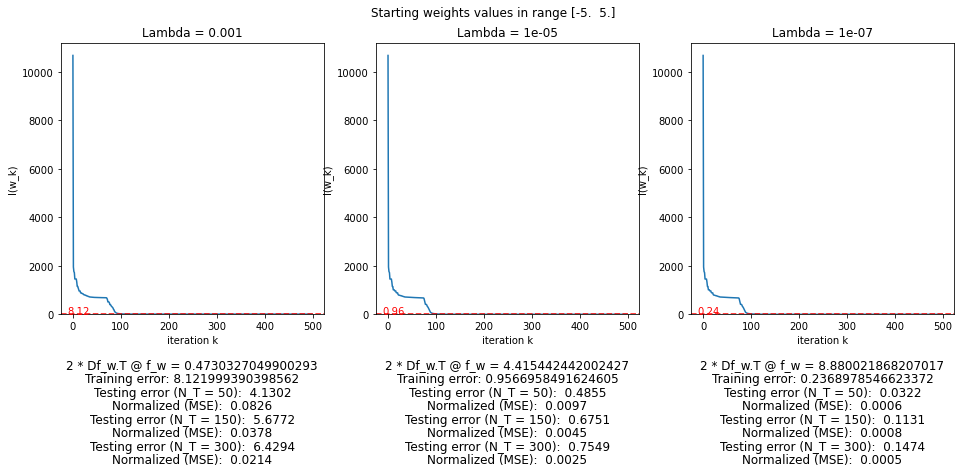

In [157]:
(l2, gamma2, w2) = approximate_function(wi_bounds, lmbs, g_new, 500, [50, 150, 300], [-2.0, 2.0])

## Comments

#### As for the other function, we don't have overfitting, and the magnitude of $\lambda$ directly correlates with the error obtained. However this time the lowest levels of $\lambda$ also have a high optimality condition

## Function visualization

#### Let's try to visualize the output of the trained Neural Network first and the output of $g(x)$ then, through intersection with $\mathbb{R}^4$

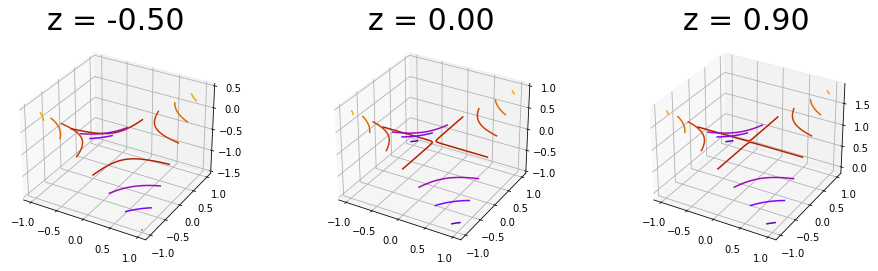

In [158]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def V(x,y,z):
     return NN(w, [x, y, z])

X,Y = np.mgrid[-1:1:100j, -1:1:100j]
Z_vals = [ -0.5, 0, 0.9 ]
num_subplots = len( Z_vals)

fig = plt.figure(figsize=(16, 4))
for i,z in enumerate( Z_vals):
    ax = fig.add_subplot(1 , num_subplots , i+1, projection='3d')
    ax.contour(X, Y, V(X,Y,z), cmap=cm.gnuplot)
    ax.set_title('z = %.2f'%z, fontsize=30)
fig.savefig('contours.png', facecolor='grey', edgecolor='none')

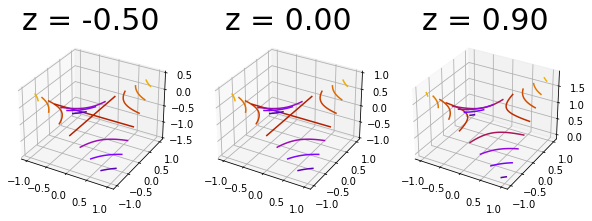

In [159]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def V(x,y,z):
     return x * y + z

X,Y = np.mgrid[-1:1:100j, -1:1:100j]
Z_vals = [ -0.5, 0, 0.9 ]
num_subplots = len( Z_vals)

fig = plt.figure(figsize=(10, 4))
for i,z in enumerate( Z_vals):
    ax = fig.add_subplot(1 , num_subplots , i+1, projection='3d')
    ax.contour(X, Y, V(X,Y,z), cmap=cm.gnuplot)
    ax.set_title('z = %.2f'%z, fontsize=30)
fig.savefig('contours.png', facecolor='grey', edgecolor='none')